# Cell type composition changes

This notebook contains code for all cell type proportion analysis, statistical testing, and visualizations for all datasets (continuous changes for aging datasets and changes across conditions for exercise/reprogramming).

**Associated manuscript figures/tables:**
- Figures: 1c,d,e
- Extended Data Figures: 3e,f,g,h; 7c,d
- Supplementary Table 6


**Inputs required:**
- `data/integrated_aging_coronal_celltyped_regioned_raw.h5ad` - AnnData object for coronal sections dataset
- `data/integrated_aging_sagittal_clustered_registered_raw.h5ad` - AnnData object for sagittal sections dataset
- `data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad` - AnnData object for exercise dataset
- `data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad` - AnnData object for reprogramming dataset


**Conda environment used**: `requirements/merfish.txt`

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import anndata as ad 
from scipy.stats import pearsonr, spearmanr
import matplotlib.colors as mcolors
import os
from scipy.stats import mannwhitneyu, ttest_ind
from decimal import Decimal

In [2]:
# function for computing confidence interval for correlations

def correlation_confidence_interval(r,n,ci=0.95):
    '''
    Given correlation (r), number of samples (n), and confidence interval (ci).
    Computes the confidence interval lower and upper bounds for r
    '''
    from scipy.stats import norm
    import math
    
    z = norm.ppf(1-(1-ci)/2)
    lower = math.tanh(math.atanh(r)-z/np.sqrt(n-3))
    upper = math.tanh(math.atanh(r)+z/np.sqrt(n-3))
    
    return((lower,upper))

# Cell type composition across age (individual cell types)

In [3]:
# read in data
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")&(adata.obs.mouse_id!="89")&(adata.obs.mouse_id!="67")]

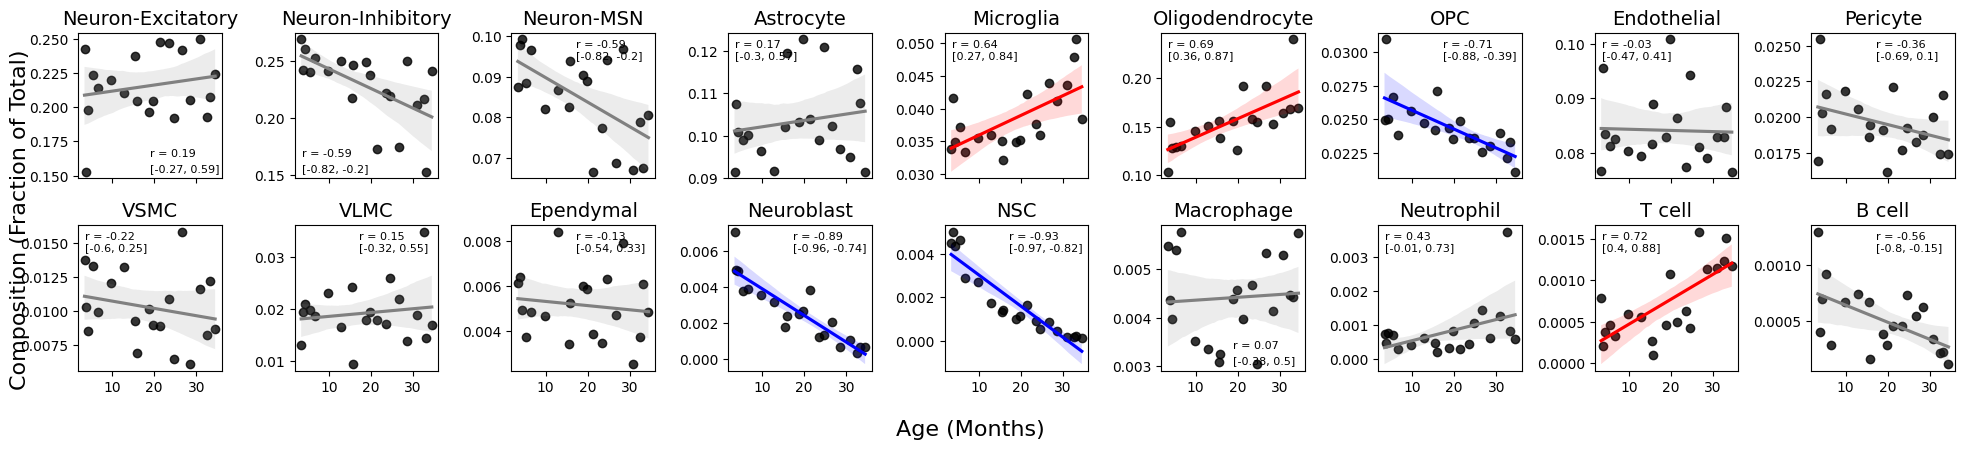

In [7]:
### CONFIDENCE INTERVAL

# Plot cell type compostion changes with age

cells_to_profile = pd.unique(adata.obs.celltype).sort_values()

denom = cells_to_profile

############################
composition_lists = []
ages = []

for s in np.unique(adata.obs["age"]):
    comp_list = []
    sample_adata = adata[adata.obs["age"]==s]
    sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
    celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                  return_counts=True)
    for ct in cells_to_profile:
        idx = np.where(celltypes==ct)
        comp_list.append(counts[idx][0]/sample_adata.shape[0])
    composition_lists.append(comp_list)
    ages.append(s)
    
comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
comp_df["age"] = ages
    

### make plot
nrows = 2
ncols = 9

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.45, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["br", "bl", "tr", "tl", "tl", "tl", "tr", "tl", "tr",
                    "tl", "tr", "tr", "tr", "tr", "br", "tl", "tl", "tr"]

fig, axs = plt.subplots(nrows, ncols, figsize=(20,4.5), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r = "+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8)
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8)
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # Regression Plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        # title
        axs[i,j].set_title(celltype, fontsize=14)
        
        counter += 1

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_coronal_PANELED_CI.pdf", bbox_inches='tight')
plt.show()

# Cell type composition across age (cell type x region)

In [10]:
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")&(adata.obs.mouse_id!="89")&(adata.obs.mouse_id!="67")].copy()

In [11]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]

In [34]:
# Generate supplementary table of region-specific cell type composition changes

cells_to_profile = pd.unique(adata.obs.celltype).sort_values()

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["br", "tl", "tl", "br", "tl", "br",
                    "tr", "tr", "bl", "tr", "tr", "tr",
                    "tl", "tl", "tr", "tr", "tl", "tl",
                    "tr", "bl", "bl", "tr", "tr", "br",]

nrows = 18
ncols = 5

regions = ["all regions", "CTX", "STR", "CC/ACO", "VEN"]

df_dict = {}
df_dict["Cell type"] = cells_to_profile

# iterate regions
for j in range(ncols):
    
    region = regions[j]
    
    if region == "all regions":
        sub_adata = adata
    else:
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()
    
    composition_lists = []
    ages = []
    
    # compute proportions
    for s in np.unique(sub_adata.obs["age"]):
        comp_list = []
        sample_adata = sub_adata[sub_adata.obs["age"]==s]
        sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
        celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                      return_counts=True)
        for ct in cells_to_profile:
            idx = np.where(celltypes==ct)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
        composition_lists.append(comp_list)
        ages.append(s)

    comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
    comp_df["age"] = ages
    
    # iterate cell types
    for i in range(nrows):
        celltype = cells_to_profile[i]
                
        # annotate stats and add to dictionary
        key_r = region+" (Pearson r)"
        key_p = region+" (P-value)"
        key_low = region+" (Lower bound 95% CI)"
        key_up = region+" (Upper bound 95% CI)"
        if key_r not in df_dict.keys():
            df_dict[key_r] = []
        if key_p not in df_dict.keys():
            df_dict[key_p] = []
        if key_low not in df_dict.keys():
            df_dict[key_low] = []
        if key_up not in df_dict.keys():
            df_dict[key_up] = []
        
        try: # COMPUTE STATS
            cobj = pearsonr(comp_df["age"], comp_df[celltype])
            r,p = cobj
            ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
            df_dict[key_r].append(r)
            df_dict[key_p].append(p)
            df_dict[key_low].append(ci[0])
            df_dict[key_up].append(ci[1])
        except:
            df_dict[key_r].append(np.nan)
            df_dict[key_p].append(np.nan)
            df_dict[key_low].append(np.nan)
            df_dict[key_up].append(np.nan)

# save dataframe
reg_comp_df = pd.DataFrame.from_dict(df_dict)
reg_comp_df.to_csv("results/cell_composition/regions_coarse_changes_all.csv", index=False)

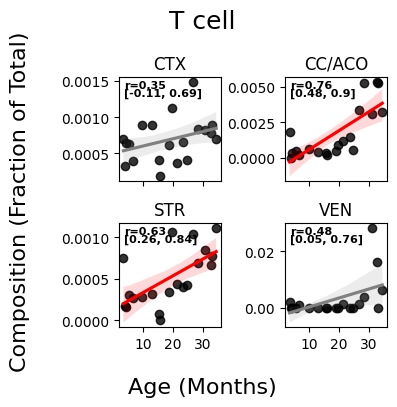

In [13]:
# CONFIDENCE INTERVAL
cell_to_profile = "T cell"

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["tl", "tl",
                    "tl", "tl",]

### make plot
nrows = 2
ncols = 2

regions = ["CTX", "STR", "CC/ACO", "VEN"]

fig, axs = plt.subplots(nrows, ncols, figsize=(4,4), sharex=True, sharey=False)


ctr = 0
for j in range(ncols):
    for i in range(nrows):
    
        region = regions[ctr]
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()

        composition_lists = []
        ages = []

        for s in np.unique(sub_adata.obs["age"]):
            comp_list = []
            sample_adata = sub_adata[sub_adata.obs["age"]==s]
            sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
            celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                          return_counts=True)
            idx = np.where(celltypes==cell_to_profile)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
            composition_lists.append(comp_list)
            ages.append(s)

        comp_df = pd.DataFrame(composition_lists, columns=[cell_to_profile])
        comp_df["age"] = ages

        celltype = cell_to_profile
    
        axs[i,j].set_title(region)
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # regression plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        ctr += 1
        

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
fig.suptitle(cell_to_profile, fontsize=18)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_coronal_PANELED_REGIONED_Tcell_coarse_CI.pdf",bbox_inches='tight')
plt.show()

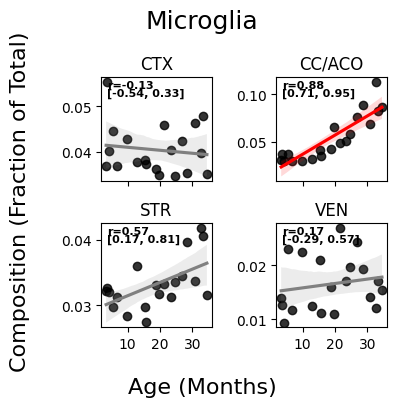

In [15]:
# CONFIDENCE INTERVAL
cell_to_profile = "Microglia"

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["tl", "tl",
                    "tl", "tl",]

### make plot
nrows = 2
ncols = 2

regions = ["CTX", "STR", "CC/ACO", "VEN"]

fig, axs = plt.subplots(nrows, ncols, figsize=(4,4), sharex=True, sharey=False)


ctr = 0
for j in range(ncols):
    for i in range(nrows):
    
        region = regions[ctr]
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()

        composition_lists = []
        ages = []

        for s in np.unique(sub_adata.obs["age"]):
            comp_list = []
            sample_adata = sub_adata[sub_adata.obs["age"]==s]
            sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
            celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                          return_counts=True)
            idx = np.where(celltypes==cell_to_profile)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
            composition_lists.append(comp_list)
            ages.append(s)

        comp_df = pd.DataFrame(composition_lists, columns=[cell_to_profile])
        comp_df["age"] = ages

        celltype = cell_to_profile
    
        axs[i,j].set_title(region)
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # regression plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        ctr += 1
        

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
fig.suptitle(cell_to_profile, fontsize=18)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_coronal_PANELED_REGIONED_Microglia_coarse_CI.pdf",bbox_inches='tight')
plt.show()

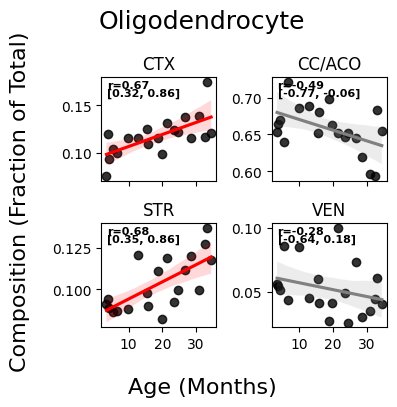

In [17]:
# CONFIDENCE INTERVAL
cell_to_profile = "Oligodendrocyte"

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["tl", "tl",
                    "tl", "tl",]

### make plot
nrows = 2
ncols = 2

regions = ["CTX", "STR", "CC/ACO", "VEN"]

fig, axs = plt.subplots(nrows, ncols, figsize=(4,4), sharex=True, sharey=False)


ctr = 0
for j in range(ncols):
    for i in range(nrows):
    
        region = regions[ctr]
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()

        composition_lists = []
        ages = []

        for s in np.unique(sub_adata.obs["age"]):
            comp_list = []
            sample_adata = sub_adata[sub_adata.obs["age"]==s]
            sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
            celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                          return_counts=True)
            idx = np.where(celltypes==cell_to_profile)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
            composition_lists.append(comp_list)
            ages.append(s)

        comp_df = pd.DataFrame(composition_lists, columns=[cell_to_profile])
        comp_df["age"] = ages

        celltype = cell_to_profile
    
        axs[i,j].set_title(region)
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # regression plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        ctr += 1
        

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
fig.suptitle(cell_to_profile, fontsize=18)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_coronal_PANELED_REGIONED_Oligodendrocyte_coarse_CI.pdf",bbox_inches='tight')
plt.show()

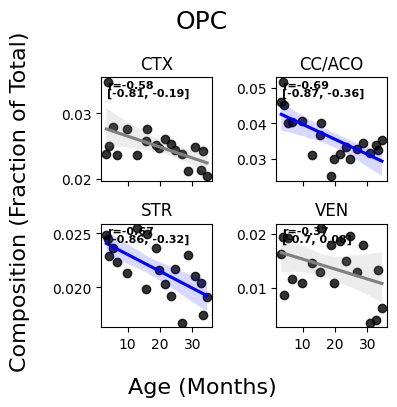

In [19]:
# CONFIDENCE INTERVAL
cell_to_profile = "OPC"

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["tl", "tl",
                    "tl", "tl",]

### make plot
nrows = 2
ncols = 2

regions = ["CTX", "STR", "CC/ACO", "VEN"]

fig, axs = plt.subplots(nrows, ncols, figsize=(4,4), sharex=True, sharey=False)


ctr = 0
for j in range(ncols):
    for i in range(nrows):
    
        region = regions[ctr]
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()

        composition_lists = []
        ages = []

        for s in np.unique(sub_adata.obs["age"]):
            comp_list = []
            sample_adata = sub_adata[sub_adata.obs["age"]==s]
            sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
            celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                          return_counts=True)
            idx = np.where(celltypes==cell_to_profile)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
            composition_lists.append(comp_list)
            ages.append(s)

        comp_df = pd.DataFrame(composition_lists, columns=[cell_to_profile])
        comp_df["age"] = ages

        celltype = cell_to_profile
    
        axs[i,j].set_title(region)
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r="+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8, weight='bold')
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # regression plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        ctr += 1
        

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
fig.suptitle(cell_to_profile, fontsize=18)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_coronal_PANELED_REGIONED_OPC_coarse_CI.pdf",bbox_inches='tight')
plt.show()

## Spatial visualization of key cell types (T cells, NSCs)

In [3]:
# read in data
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")&(adata.obs.mouse_id!="89")&(adata.obs.mouse_id!="67")]

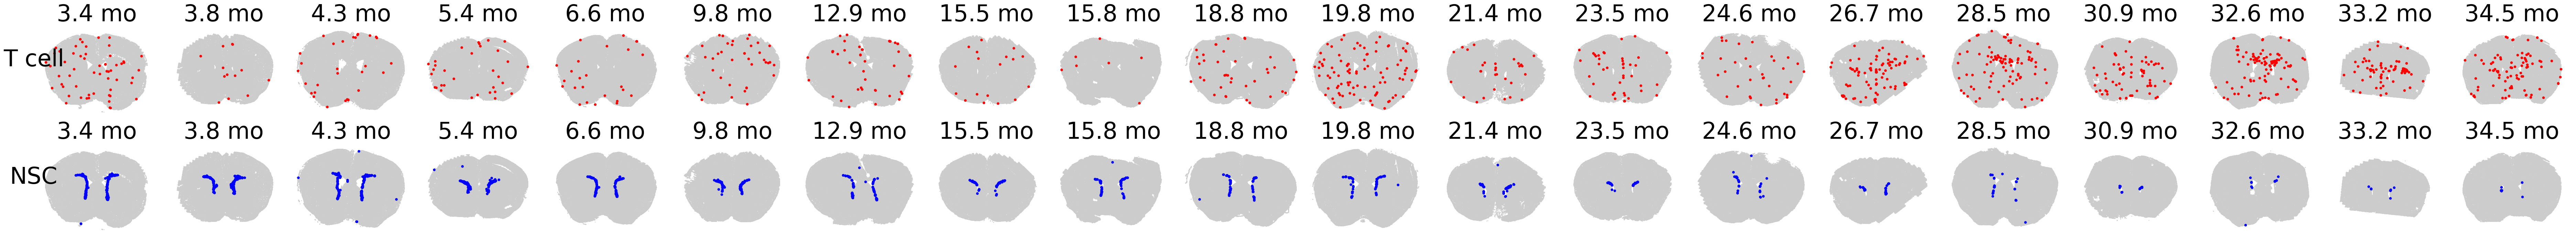

In [4]:
cells_to_profile = ["T cell", "NSC"]
color_key = {"T cell": "r", "NSC": "b"}

ages_to_profile = np.unique(adata.obs.age)

############################

### make plot
nrows = len(cells_to_profile)
ncols = len(ages_to_profile)

fig, axs = plt.subplots(nrows, ncols, figsize=(75,7), sharex=True, sharey=True)

for j in range(ncols):
    
    age = np.unique(adata.obs.age)[j] # get age
    
    for i in range(nrows):
        
        celltype = cells_to_profile[i] # get cell type
        
        # subset
        sub_adata = adata[adata.obs['age']==age]

        # make spatial plots
        axs[i,j].scatter(sub_adata[sub_adata.obs.celltype!=celltype].obsm["spatial"][:,0],
                     sub_adata[sub_adata.obs.celltype!=celltype].obsm["spatial"][:,1],
                     c='0.8', s=0.5, rasterized=True)
        axs[i,j].scatter(sub_adata[sub_adata.obs.celltype==celltype].obsm["spatial"][:,0],
                     sub_adata[sub_adata.obs.celltype==celltype].obsm["spatial"][:,1],
                     c=color_key[celltype], s=20, rasterized=True)
        axs[i,j].set_title(str(age)+" mo",fontsize=48)
        
        # turn off all axis elements except for label
        # make xaxis invisibel
        axs[i,j].xaxis.set_visible(False)
        # make spines (the box) invisible
        plt.setp(axs[i,j].spines.values(), visible=False)
        # remove ticks and labels for the left axis
        axs[i,j].tick_params(left=False, labelleft=False)
        #remove background patch (only needed for non-white background)
        axs[i,j].patch.set_visible(False)

# set ylabel for first column
for ax, row in zip(axs[:,0], cells_to_profile):
    ax.set_ylabel(row, rotation=0, fontsize=48)
        
# make figure
plt.tight_layout()
plt.savefig("plots/cell_composition/spatial_age_cell_type_tcellnsc.pdf",bbox_inches='tight',dpi=300)
plt.show()

# Sagittal sections

In [8]:
adata = sc.read_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")
adata = adata[(adata.obs.clusters!="1")]

In [6]:
# Generate supplementary table of region-specific cell type composition changes

cells_to_profile = pd.unique(adata.obs.celltype).sort_values()

denom = pd.unique(adata.obs.celltype).sort_values()

############################

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.5, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["br", "tl", "tl", "br", "tl", "br",
                    "tr", "tr", "bl", "tr", "tr", "tr",
                    "tl", "tl", "tr", "tr", "tl", "tl",
                    "tr", "bl", "bl", "tr", "tr", "br",]

nrows = 18
ncols = 1

regions = ["all regions"]

df_dict = {}
df_dict["Cell type"] = cells_to_profile

# iterate regions
for j in range(ncols):
    
    region = regions[j]
    
    if region == "all regions":
        sub_adata = adata
    else:
        sub_adata = adata[adata.obs["region_coarse"]==region].copy()
    
    composition_lists = []
    ages = []
    
    # compute proportions
    for s in np.unique(sub_adata.obs["age"]):
        comp_list = []
        sample_adata = sub_adata[sub_adata.obs["age"]==s]
        sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
        celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                      return_counts=True)
        for ct in cells_to_profile:
            idx = np.where(celltypes==ct)
            if len(idx[0]) == 0:
                comp_list.append(0)
            else:
                comp_list.append(counts[idx][0]/sample_adata.shape[0])
        composition_lists.append(comp_list)
        ages.append(s)

    comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
    comp_df["age"] = ages
    
    # iterate cell types
    for i in range(nrows):
        celltype = cells_to_profile[i]
                
        # annotate stats and add to dictionary
        key_r = region+" (Pearson r)"
        key_p = region+" (P-value)"
        key_low = region+" (Lower bound 95% CI)"
        key_up = region+" (Upper bound 95% CI)"
        if key_r not in df_dict.keys():
            df_dict[key_r] = []
        if key_p not in df_dict.keys():
            df_dict[key_p] = []
        if key_low not in df_dict.keys():
            df_dict[key_low] = []
        if key_up not in df_dict.keys():
            df_dict[key_up] = []
        
        try: # COMPUTE STATS
            cobj = pearsonr(comp_df["age"], comp_df[celltype])
            r,p = cobj
            ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
            df_dict[key_r].append(r)
            df_dict[key_p].append(p)
            df_dict[key_low].append(ci[0])
            df_dict[key_up].append(ci[1])
        except:
            df_dict[key_r].append(np.nan)
            df_dict[key_p].append(np.nan)
            df_dict[key_low].append(np.nan)
            df_dict[key_up].append(np.nan)

# save dataframe
reg_comp_df = pd.DataFrame.from_dict(df_dict)
reg_comp_df.to_csv("results/cell_composition/sagittal_changes_all.csv", index=False)

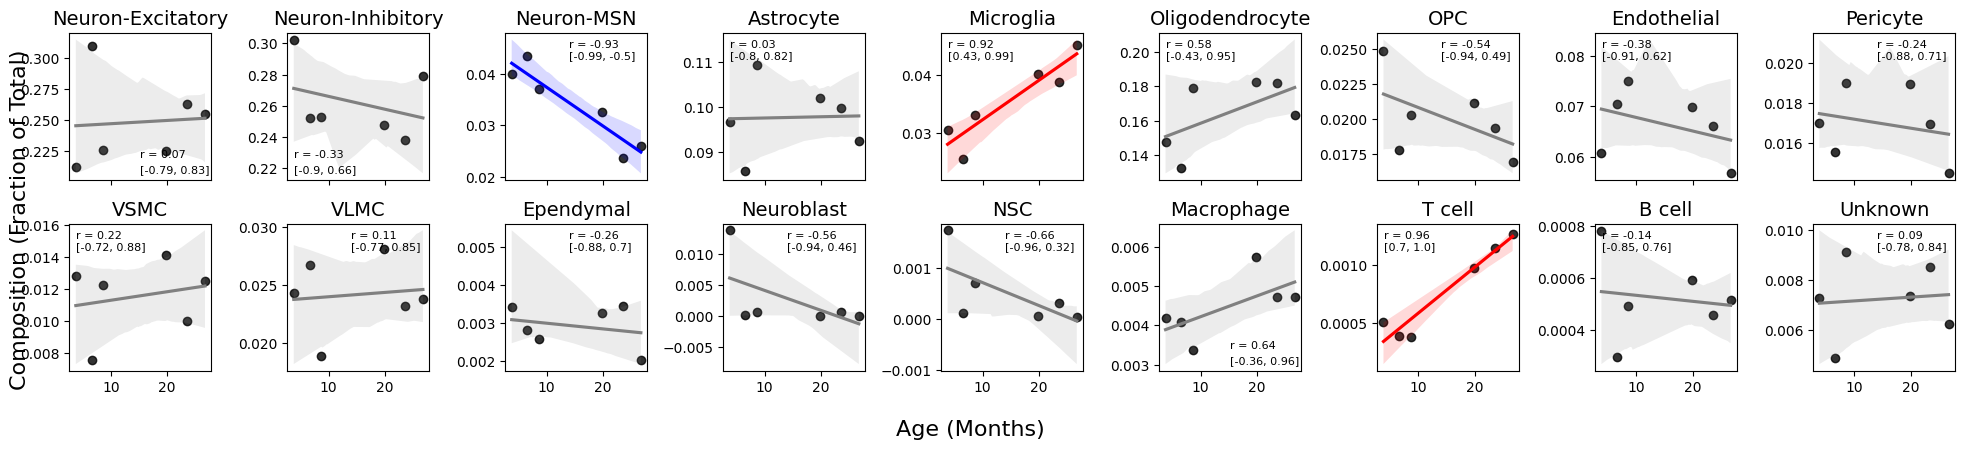

In [9]:
# CONFIDENCE INTERVAL

cells_to_profile = pd.unique(adata.obs.celltype).sort_values()

denom = cells_to_profile

############################
composition_lists = []
ages = []

for s in np.unique(adata.obs["age"]):
    comp_list = []
    sample_adata = adata[adata.obs["age"]==s]
    sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
    celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                  return_counts=True)
    for ct in cells_to_profile:
        idx = np.where(celltypes==ct)
        comp_list.append(counts[idx][0]/sample_adata.shape[0])
    composition_lists.append(comp_list)
    ages.append(s)
    
comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
comp_df["age"] = ages
    

### make plot
nrows = 2
ncols = 9

pos_dict = {"br": (0.5, 0.15, 0.05),
            "bl": (0.05, 0.15, 0.05),
            "tr": (0.45, 0.9, 0.825),
            "tl": (0.05, 0.9, 0.825)}
corner_for_annot = ["br", "bl", "tr", "tl", "tl", "tl", "tr", "tl", "tr",
                    "tl", "tr", "tr", "tr", "tr", "br", "tl", "tl", "tr"]

fig, axs = plt.subplots(nrows, ncols, figsize=(20,4.5), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        
        # annotate stats
        r,p = pearsonr(comp_df["age"], comp_df[celltype])
        ci = correlation_confidence_interval(r,len(comp_df["age"]),0.95)
        x, y1, y2 = pos_dict[corner_for_annot[j+i*ncols]]
        axs[i,j].text(x, y1, "r = "+str(round(r,2)), transform=axs[i,j].transAxes, 
            size=8)
        axs[i,j].text(x, y2, f"[{round(ci[0],2)}, {round(ci[1],2)}]", transform=axs[i,j].transAxes, 
            size=8)
        
        # shading color based on statistical trends
        if (r>0) and (ci[0]>0.25):
            shade_color = "r"
        elif (r<0) and (ci[1]<-0.25):
            shade_color = "b"
        else:
            shade_color = '0.5'
        
        # Regression Plot
        sns.regplot(comp_df, x="age", y=celltype, ci=95, ax=axs[i,j],
                    scatter_kws={"color": "black"}, line_kws={"color": shade_color})
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        # title
        axs[i,j].set_title(celltype, fontsize=14)
        
        counter += 1

# make figure
fig.supxlabel("Age (Months)", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/cell_composition/integrated_sagittal_PANELED_CI.pdf", bbox_inches='tight')
plt.show()

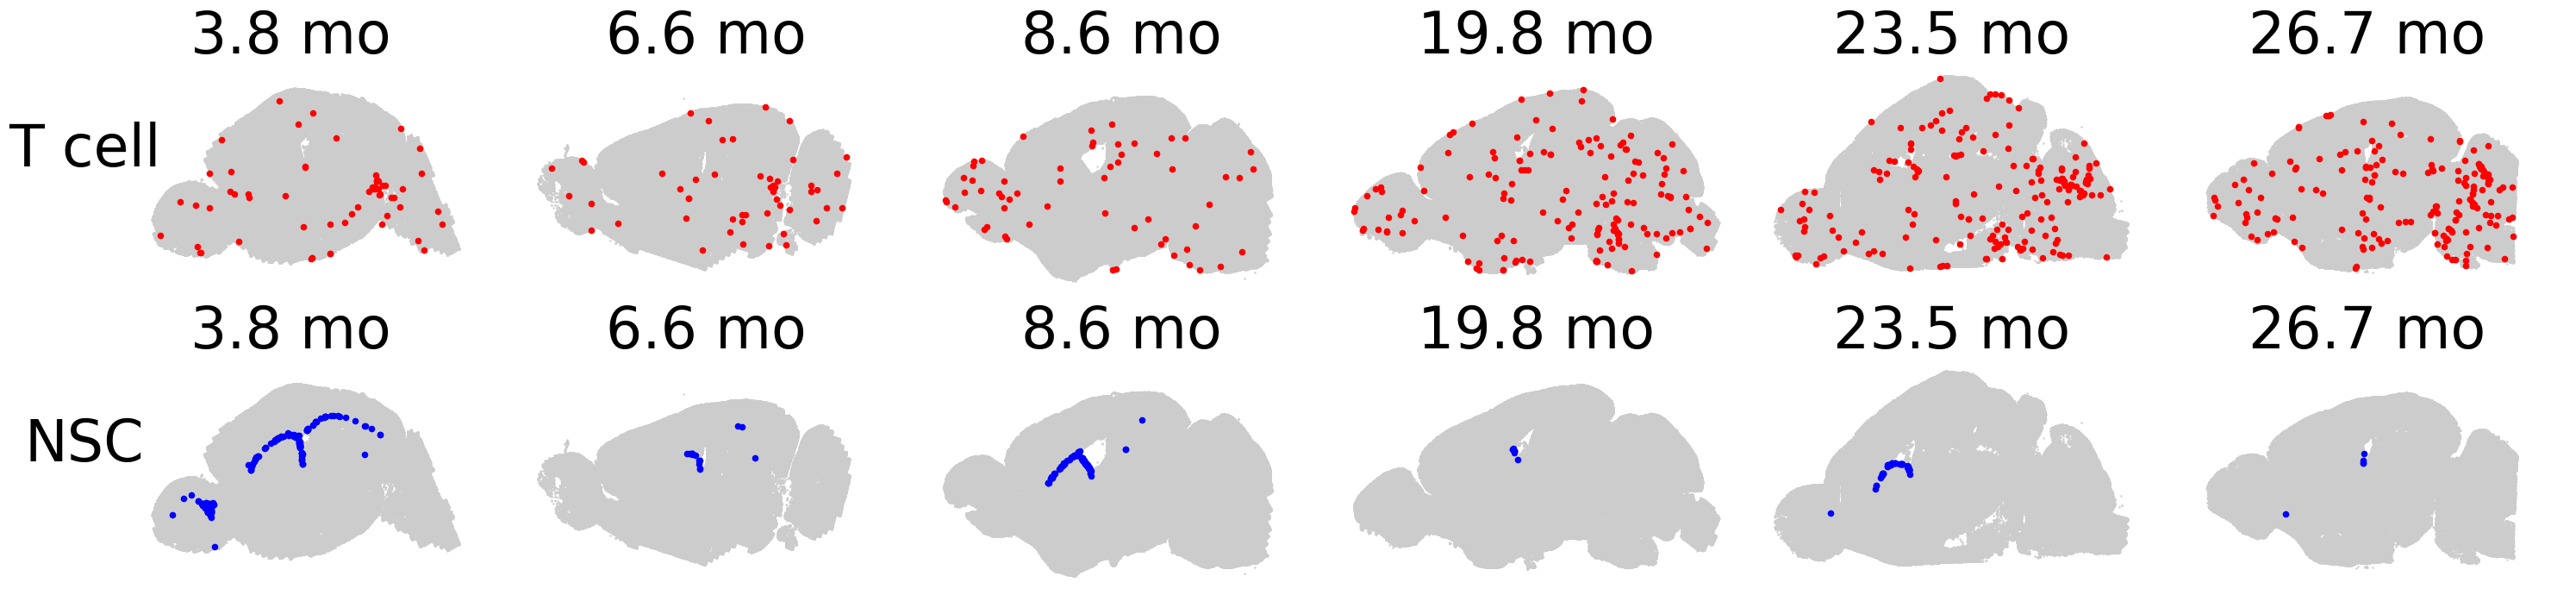

In [5]:
cells_to_profile = ["T cell", "NSC"]
color_key = {"T cell": "r", "NSC": "b"}

ages_to_profile = np.unique(adata.obs.age)

############################

### make plot
nrows = len(cells_to_profile)
ncols = len(ages_to_profile)

fig, axs = plt.subplots(nrows, ncols, figsize=(30,7), sharex=True, sharey=True)

for j in range(ncols):
    
    age = np.unique(adata.obs.age)[j] # get age
    
    for i in range(nrows):
        
        celltype = cells_to_profile[i] # get cell type
        
        # subset
        sub_adata = adata[adata.obs['age']==age]

        # make spatial plots
        axs[i,j].scatter(sub_adata[sub_adata.obs.celltype!=celltype].obsm["spatial"][:,0],
                     sub_adata[sub_adata.obs.celltype!=celltype].obsm["spatial"][:,1],
                     c='0.8', s=0.5, rasterized=True)
        axs[i,j].scatter(sub_adata[sub_adata.obs.celltype==celltype].obsm["spatial"][:,0],
                     sub_adata[sub_adata.obs.celltype==celltype].obsm["spatial"][:,1],
                     c=color_key[celltype], s=20, rasterized=True)
        axs[i,j].set_title(str(age)+" mo",fontsize=48)
        
        # turn off all axis elements except for label
        # make xaxis invisible
        axs[i,j].xaxis.set_visible(False)
        # make spines (the box) invisible
        plt.setp(axs[i,j].spines.values(), visible=False)
        # remove ticks and labels for the left axis
        axs[i,j].tick_params(left=False, labelleft=False)
        #remove background patch (only needed for non-white background)
        axs[i,j].patch.set_visible(False)

# set ylabel for first column
for ax, row in zip(axs[:,0], cells_to_profile):
    ax.set_ylabel(row, rotation=0, fontsize=48)
        
# make figure
plt.tight_layout()
plt.savefig("plots/cell_composition/spatial_age_cell_type_tcellnsc_sagittal.pdf",bbox_inches='tight',dpi=300)
plt.show()

# Exercise

In [ ]:
adata = sc.read_h5ad("data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [8]:
categories_order = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
adata.obs['celltype'] = adata.obs['celltype'].astype('category').cat.reorder_categories(categories_order)

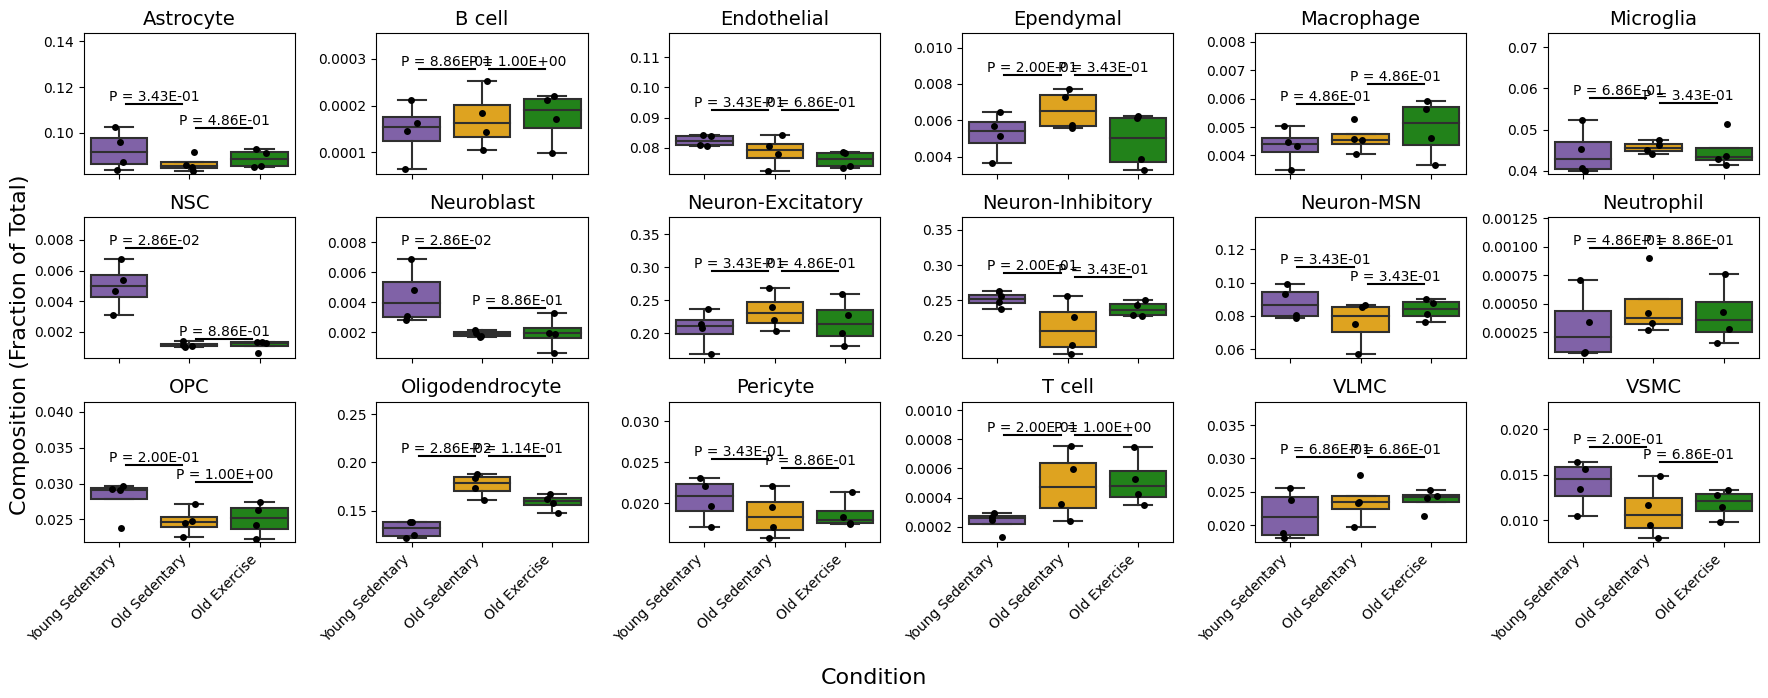

In [10]:
cells_to_profile = np.unique(adata.obs.celltype)

denom = np.unique(adata.obs.celltype)

############################
composition_lists = []
ages = []
mouse_ids = []

for s in np.unique(adata.obs["mouse_id"]):
    comp_list = []
    sample_adata = adata[adata.obs["mouse_id"]==s]
    sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
    celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                  return_counts=True)
    for ct in cells_to_profile:
        idx = np.where(celltypes==ct)
        comp_list.append(counts[idx][0]/sample_adata.shape[0])
    composition_lists.append(comp_list)
    mouse_ids.append(s)
    ages.append(sample_adata.obs['cohort'].values[0])
    
comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
comp_df["cohort"] = ages
    

### make plot
nrows = 3
ncols = 6

palette = {"Young Sedentary":"#7F57B2",
           "Old Exercise":"#149309",
           "Old Sedentary":"#FEAF00"}

condition_mapper = {
    "young_control":"Young Sedentary",
    "old_exercise":"Old Exercise",
    "old_control":"Old Sedentary"
}

comp_df["cohort"] = [condition_mapper[x] for x in comp_df["cohort"]]


fig, axs = plt.subplots(nrows, ncols, figsize=(18,7), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        if counter < len(np.unique(adata.obs['celltype'])):
        
            celltype = list(np.unique(adata.obs['celltype']))[counter]

            sns.stripplot(comp_df, x="cohort", y=celltype, color='k', ax=axs[i,j],
                          order=["Young Sedentary","Old Sedentary","Old Exercise"])
            sns.boxplot(comp_df, x="cohort", y=celltype, palette=palette, ax=axs[i,j],
                        order=["Young Sedentary","Old Sedentary","Old Exercise"], showfliers=False)
            axs[i,j].set_title(celltype, fontsize=14)
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            axs[i,j].set_xticks(axs[i,j].get_xticks(), axs[i,j].get_xticklabels(), rotation=45, ha='right')
        
            # statistical annotation
            x_coords = [0.5, 1.5]
            y_coords = [np.max(comp_df[comp_df["cohort"].isin(["Old Sedentary","Young Sedentary"])][celltype])*1.1,
                        np.max(comp_df[comp_df["cohort"].isin(["Old Sedentary","Old Exercise"])][celltype])*1.1]*2
            cols = ['k']*2
            h = 0
            w = 0.4
            t,p1 = mannwhitneyu(comp_df[comp_df["cohort"]=="Old Sedentary"][celltype], comp_df[comp_df["cohort"]=="Young Sedentary"][celltype])
            t,p2 = mannwhitneyu(comp_df[comp_df["cohort"]=="Old Sedentary"][celltype], comp_df[comp_df["cohort"]=="Old Exercise"][celltype])
            pval_labels = [p1, p2]
            for pi, label in enumerate(pval_labels):
                p_label = "P = "+ '%.2E' % Decimal(str(label))
                x1, x2, y, col = x_coords[pi]-w, x_coords[pi]+w, y_coords[pi], cols[pi]
                axs[i,j].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                axs[i,j].text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=10)
            axs[i,j].set_ylim(None,np.max(comp_df[celltype])*1.4)
        
        counter += 1

# make figure
fig.supxlabel("Condition", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/exercise/integrated_coronal_PANELED_exercise.pdf", bbox_inches='tight')
plt.show()

# Reprogramming

In [6]:
adata = sc.read_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [13]:
categories_order = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage']
adata.obs['celltype'] = adata.obs['celltype'].astype('category').cat.reorder_categories(categories_order)

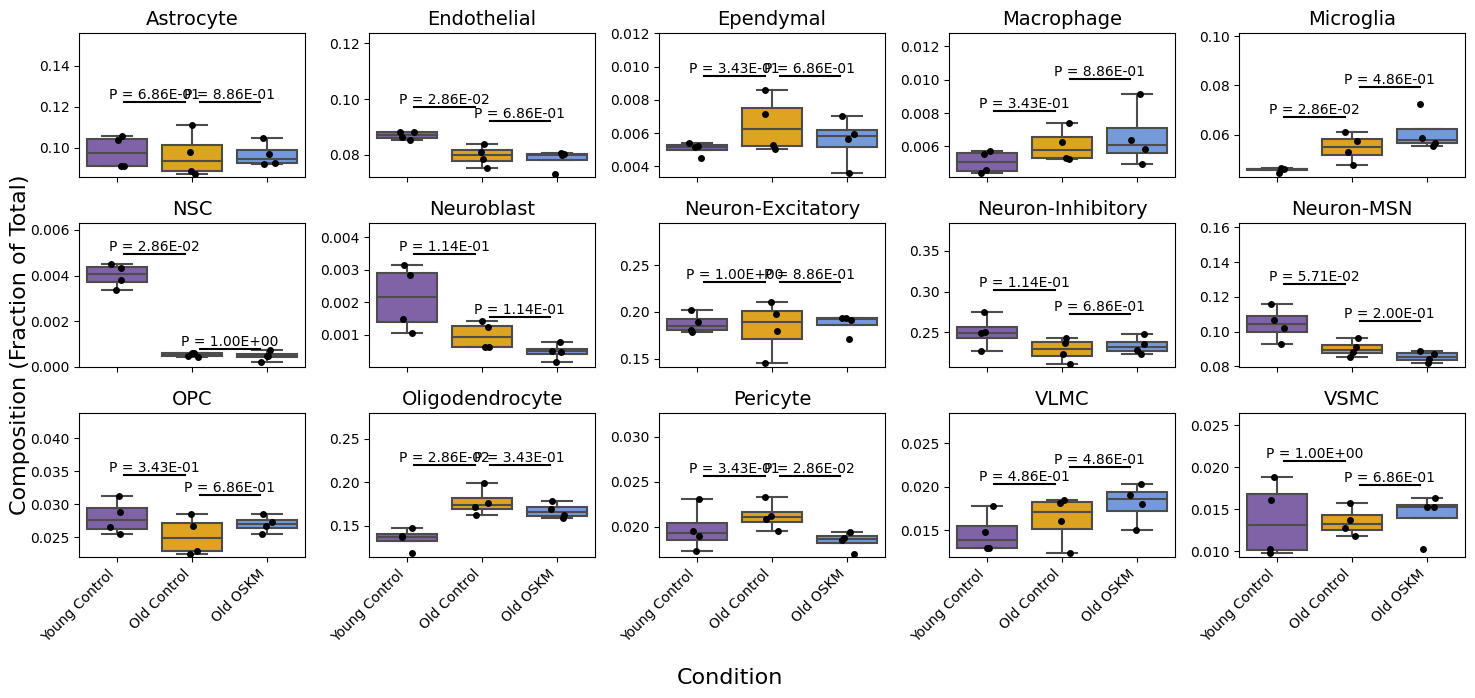

In [15]:
cells_to_profile = np.unique(adata.obs.celltype)

denom = np.unique(adata.obs.celltype)

############################
composition_lists = []
ages = []
mouse_ids = []

for s in np.unique(adata.obs["mouse_id"]):
    comp_list = []
    sample_adata = adata[adata.obs["mouse_id"]==s]
    sample_adata = sample_adata[sample_adata.obs['celltype'].isin(denom)]
    celltypes, counts = np.unique(sample_adata.obs["celltype"],
                                  return_counts=True)
    for ct in cells_to_profile:
        idx = np.where(celltypes==ct)
        comp_list.append(counts[idx][0]/sample_adata.shape[0])
    composition_lists.append(comp_list)
    mouse_ids.append(s)
    ages.append(sample_adata.obs['cohort'].values[0])
    
comp_df = pd.DataFrame(composition_lists, columns=cells_to_profile)
comp_df["cohort"] = ages
    

### make plot
nrows = 3
ncols = 5

palette = {"Young Control":"#7F57B2",
           "Old OSKM":"cornflowerblue",
           "Old Control":"#FEAF00"}

condition_mapper = {
    "young_notreatment":"Young Control",
    "old_treatment":"Old OSKM",
    "old_notreatment":"Old Control"
}

comp_df["cohort"] = [condition_mapper[x] for x in comp_df["cohort"]]


fig, axs = plt.subplots(nrows, ncols, figsize=(15,7), sharex=True, sharey=False)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        if counter < len(np.unique(adata.obs['celltype'])):
        
            celltype = list(np.unique(adata.obs['celltype']))[counter]

            sns.stripplot(comp_df, x="cohort", y=celltype, color='k', ax=axs[i,j],
                          order=["Young Control","Old Control","Old OSKM"])
            sns.boxplot(comp_df, x="cohort", y=celltype, palette=palette, ax=axs[i,j],
                        order=["Young Control","Old Control","Old OSKM"], showfliers=False)
            axs[i,j].set_title(celltype, fontsize=14)
            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            axs[i,j].set_xticks(axs[i,j].get_xticks(), axs[i,j].get_xticklabels(), rotation=45, ha='right')
        
            # statistical annotation
            x_coords = [0.5, 1.5]
            y_coords = [np.max(comp_df[comp_df["cohort"].isin(["Old Control","Young Control"])][celltype])*1.1,
                        np.max(comp_df[comp_df["cohort"].isin(["Old Control","Old OSKM"])][celltype])*1.1]*2
            cols = ['k']*2
            h = 0
            w = 0.4
            t,p1 = mannwhitneyu(comp_df[comp_df["cohort"]=="Old Control"][celltype], comp_df[comp_df["cohort"]=="Young Control"][celltype],)
            t,p2 = mannwhitneyu(comp_df[comp_df["cohort"]=="Old Control"][celltype], comp_df[comp_df["cohort"]=="Old OSKM"][celltype],)
            pval_labels = [p1, p2]
            for pi, label in enumerate(pval_labels):
                p_label = "P = "+ '%.2E' % Decimal(str(label))
                x1, x2, y, col = x_coords[pi]-w, x_coords[pi]+w, y_coords[pi], cols[pi]
                axs[i,j].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                axs[i,j].text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=10)
            axs[i,j].set_ylim(None,np.max(comp_df[celltype])*1.4)
        
        counter += 1

# make figure
fig.supxlabel("Condition", fontsize=16)
fig.supylabel("Composition (Fraction of Total)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/reprogramming/integrated_coronal_PANELED_reprogramming.pdf", bbox_inches='tight')
plt.show()